# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [2]:
from workspace_utils import *

In [3]:
from unityagents import UnityEnvironment
from ddpg_agent import Agent
from collections import deque
from collections import deque
from itertools import count
from workspace_utils import active_session
 
import numpy as np
import time
import random
import torch
import matplotlib.pyplot as plt

In [4]:
from unityagents import UnityEnvironment
import numpy as np

# select this option to load version 1 (with a single agent) of the environment
env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# select this option to load version 2 (with 20 agents) of the environment
# env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [5]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [6]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726671e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


### Deep Determinist Policy Gradient

- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [7]:
from unityagents import UnityEnvironment
from ddpg_agent import Agent
from collections import deque
import numpy as np
import torch

def ddpg(n_episodes=2000, max_t=1000, print_every=100, consec_episodes=100, goal_score=30.0):
    
    scores_deque = deque(maxlen=consec_episodes)
    score = []
    
    for i_episode in range(1, n_episodes+1):
        
        env_info = env.reset(train_mode=True)[brain_name] 
        agent.reset()
        
        states = env_info.vector_observations 
        scores = np.zeros((1,))
                
        for timestep in range(max_t):
            actions = agent.act(states)
            
            env_info = env.step(actions)[brain_name]            # send all actions to the environment
            next_states = env_info.vector_observations          # get next state (for each agent)
            rewards = env_info.rewards                          # get reward (for each agent)
            
            dones = env_info.local_done                         # see if episode finished
            
            agent.step(states, actions, rewards, next_states, dones, timestep)
            
            scores += env_info.rewards                           # update the score (for each agent)
            states = next_states                                # roll over states to next time step
            
            if np.any(dones):                                   # exit loop if episode finished
                break
                
        scores_deque.append(scores)
        score.append(scores)
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)), end="")

        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}\tMax Value in Window: {:.2f}\tMin Value in Window: {:.2f}'.
                  format(i_episode, np.mean(scores_deque), np.max(scores_deque), np.min(scores_deque)))
            
        if np.mean(scores_deque) >= goal_score:
                print('\n Requirements Satisfied in ' + str(i_episode) + ' episodes')
                torch.save(agent.actor_local.state_dict(), "agen_weights.pth")
                torch.save(agent.critic_local.state_dict(), "critic_weights.pth")
                
                break
            
    return scores, score

In [8]:
env_info = env.reset(train_mode=True)[brain_name]
agent = Agent(state_size=env_info.vector_observations.shape[1], action_size=brain.vector_action_space_size, random_seed=2)

num_agents = len(env_info.agents)
action_size = brain.vector_action_space_size

with active_session():
    scores, score = ddpg()
    

/home/workspace/ddpg_agent.py:107: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(self.critic_local.parameters(),1)


Episode 100	Average Score: 1.38	Max Value in Window: 4.80	Min Value in Window: 0.00
Episode 200	Average Score: 4.76	Max Value in Window: 15.13	Min Value in Window: 1.47
Episode 300	Average Score: 9.90	Max Value in Window: 27.38	Min Value in Window: 2.27
Episode 400	Average Score: 17.64	Max Value in Window: 34.69	Min Value in Window: 7.74
Episode 500	Average Score: 22.62	Max Value in Window: 38.95	Min Value in Window: 5.27
Episode 571	Average Score: 30.05
 Requirements Satisfied in 571 episodes


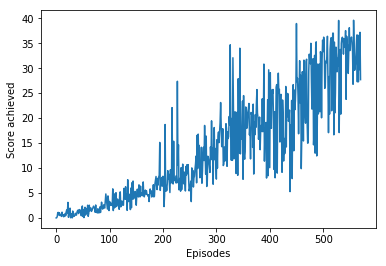

In [9]:
plt.plot(np.arange(0, len(score)), score)
plt.ylabel('Score achieved')
plt.xlabel('Episodes')
plt.show()